In [1]:
%load_ext autoreload

import random as r
import json

from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from AbstractArchitecture import AbstractArchitecture
from DenseEncoder import DenseEncoder
from DenseDecoder import DenseDecoder
from NormalizedMeanSquaredError import NormalizedMeanSquaredError as NMSE
from plot_model_prediction import plot_model_prediction

In [2]:
# Set Experiment Specifics
expt_name = "Experiment_01"
data_file_prefix = './data/NLSL_expt1'  ## FILL IN HERE (from file name)

# Network architecture design
l = 20  # Latent space size

activation = "relu"
initializer = tf.keras.initializers.VarianceScaling()
reg_lambda_l2 = 1e-6
regularizer = tf.keras.regularizers.l2(reg_lambda_l2)

act_layer = dict(activation=activation,
                 kernel_initializer=initializer,
                 kernel_regularizer=regularizer)
lin_layer = dict(activation=None,
                 kernel_initializer=initializer,
                 kernel_regularizer=regularizer)
# For experiment 00 and 02:
#latent_config = dict(activation=None, 
#                     kernel_regularizer=regularizer,
#                     use_bias=False)
# For experiment 01:
latent_config = dict(activation=None)

encoder_layers = 3
decoder_layers = 4
add_identity = True

# Model training settings
## Set optimizer
optimizer = keras.optimizers.Adam
optimizer_opts = {}

# Callback function(s) and fit method options
cbs = [keras.callbacks.EarlyStopping(patience=10)]

# Batch size for model training
batch_size = 64


############################################
### Reconstruct the appropriate model ###
############################################
## Set the model weight paths:
model_weight_path = "./data/{}_final_model_weights.tf".format(expt_name)

# Step 1. Load in the data
data_train_u = np.load("{}_train1_u.npy".format(data_file_prefix))
data_train_f = np.load("{}_train1_f.npy".format(data_file_prefix))
data_val_u = np.load("{}_val_u.npy".format(data_file_prefix))
data_val_f = np.load("{}_val_f.npy".format(data_file_prefix))
data_test_u1 = np.load("{}_test1_u.npy".format(data_file_prefix))
data_test_f1 = np.load("{}_test1_f.npy".format(data_file_prefix))
data_test_u = np.load("{}_test2_u.npy".format(data_file_prefix))
data_test_f = np.load("{}_test2_f.npy".format(data_file_prefix))

# Step 2. Set up the model architecture
_, n = data_train_u.shape

encoder_config = {'units_full': n,
                  'num_layers': encoder_layers,
                  'actlay_config': act_layer,
                  'linlay_config': lin_layer,
                  'add_init_fin': add_identity}

decoder_config = {'units_full': n,
                  'num_layers': decoder_layers,
                  'actlay_config': act_layer,
                  'linlay_config': lin_layer,
                  'add_init_fin': add_identity}

# Aggregate settings for model architecture
architecture_config = {"units_latent": l,
                       "u_encoder_block": DenseEncoder(**encoder_config),
                       "u_decoder_block": DenseDecoder(**decoder_config),
                       "F_encoder_block": DenseEncoder(**encoder_config),
                       "F_decoder_block": DenseDecoder(**decoder_config),
                       "latent_config": latent_config}



## Step 5. Set up the full architecture run!!

# Set up validation data, loss functions, and number of epochs
val_data = [(data_val_u, data_val_f), 
            (data_val_u, data_val_f, data_val_f, data_val_u)]
loss_fns = 4*[NMSE()]

# Instantiate the new model
full_model = AbstractArchitecture(**architecture_config,
                                  train_autoencoders_only=False)


# Load the weights
full_model.load_weights(model_weight_path)
#full_model.compile(loss=loss_fns, optimizer=optimizer())


In [3]:
u_aec, f_aec, f_pred, u_pred = full_model.predict(x=[data_val_u, data_val_f])

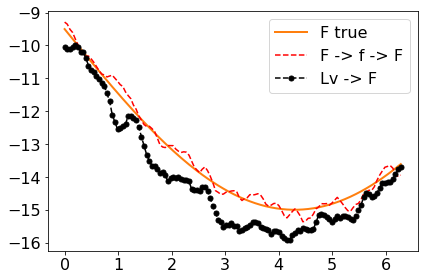

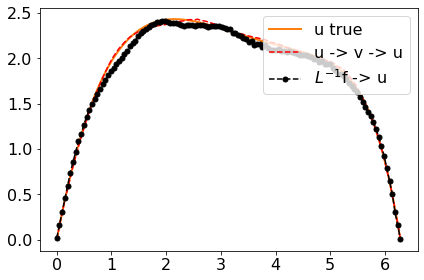

In [4]:
plot_model_prediction(full_model, 4, data_val_u, data_val_f)

In [5]:
L = full_model.Operator.get_operator()

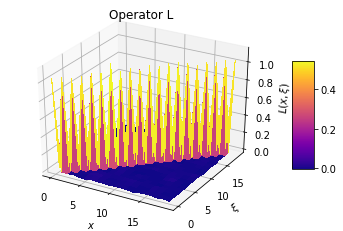

In [6]:
x = np.arange(0,20)
y = np.arange(0,20)
X, Y = np.meshgrid(x, y)

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title("Operator L")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\xi$")
ax.set_zlabel(r"$L(x,\xi)$")
surf = ax.plot_surface(X, Y, L, cmap=cm.plasma, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [7]:
G = np.linalg.inv(L)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


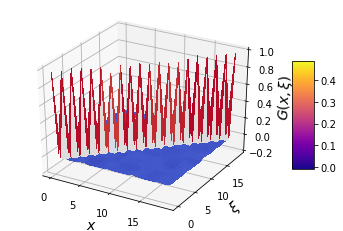

In [8]:
%matplotlib inline
import matplotlib as mpl
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

mpl.rcParams['animation.embed_limit'] = 2**128


elevations = np.linspace(10, 70, 60).tolist()
azimuthals = np.linspace(30, 90, 60).tolist()
azimuthals2 = np.linspace(90, 150, 60).tolist()

#combinations = [(elev, azimuthals[0]) for elev in elevations]
#combos1.reverse()
combinations = [(elev, azim) for (elev, azim) in zip(elevations, azimuthals)]
#azimuthals2.reverse()
elevations.reverse()
combinations += [(elev, azim) for (elev, azim) in zip(elevations, azimuthals2)]

azimuthals.reverse()
azimuthals2.reverse()
all_azimuthals = azimuthals2 + azimuthals
combinations += [(elevations[-1], azim) for azim in all_azimuthals]
#elevations.reverse()
#combinations += [(elev, azim) for (elev, azim) in zip(elevations, azimuthals)]



# Plot the surface.
fig = plt.figure()
plt.title("NN-Generated Operator L")
ax = fig.gca(projection='3d')
options = dict(cmap=cm.plasma, antialiased=False)
surf = ax.plot_surface(X, Y, G, **options)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

# Set font size for axis labels
fs = 14
# Set the z axis limits
ax.set_zlim(-0.2, 1.0)
# Label the axes
ax.set_xlabel(r"$x$", fontsize=fs)
ax.set_ylabel(r"$\xi$", fontsize=fs)
ax.set_zlabel(r'$G(x, \xi)$', fontsize=fs)

options = dict(cmap=cm.coolwarm, linewidth=0, antialiased=False)

def init():
    # Plot the surface
    surf = ax.plot_surface(X, Y, G, **options)
    return fig,

def animate_plots(i, ax, combinations):
    elev, azim = combinations[i]
    ax.view_init(elev, azim)
    return fig,

animate_func = lambda i, axes=ax, combinations=combinations: animate_plots(i, axes, combinations)

anim = FuncAnimation(fig, animate_func, init_func=init, frames=len(combinations), interval=30, blit=False)

plt.show()

In [9]:
HTML(anim.to_html5_video())

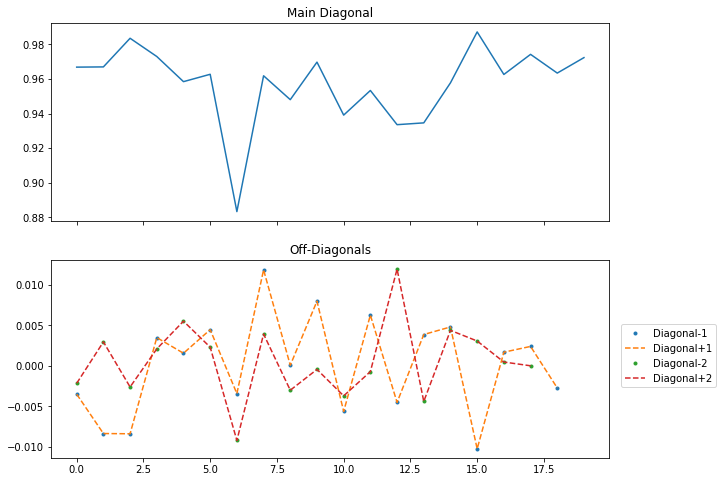

In [10]:
# A closer look at the operator...
fig, [ax1, ax2] = plt.subplots(2,1, sharex=True, figsize=(10,8))
ax1.set_title("Main Diagonal")
ax1.plot(np.diagonal(G), label="Main Diagonal")
ax2.set_title("Off-Diagonals")
for i in range(2):
    i = i+1
    ax2.plot(np.diagonal(G, offset=-1*i), '.', label="Diagonal-{}".format(i))
    ax2.plot(np.diagonal(G, offset=i), '--', label="Diagonal+{}".format(i))
plt.legend(bbox_to_anchor=(1.2,0.7))
plt.show()